# Exercise group: Rui Zhao, Qianli Wang, Nazar Sopiha

**Exercise 1**: 

(a) Reduce the "ZIP-code"-dataset to two dimensions using Oja’s algorithm and plot thepoint cloud of the data set highlighting each class.

(b) Try one of the previously implemented classifiers (k-NN or Logistic Regression) on thetwo-dimensional dataset.

In [239]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [240]:
training_data = np.array(pd.read_csv('Data/zip.train', sep=' ', header=None))
test_data = np.array(pd.read_csv('Data/zip.test', sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7291, 256)
(7291,)
(2007, 256)
(2007,)


In [241]:
import random

def normalize(v): 
    norm = np.linalg.norm(v)

    if norm == 0: 
        return v 
    return v / norm

def PCA(data, size):
    # initialize w 
    w = np.ones((size, ))
    w = normalize(w)
    counter = 1
    learning_rate = 0.1
    
    while(counter <= 1000):
        # pick a random x
        random_number = random.randint(0, data.shape[0]-1)
        x = data[random_number].reshape(size,)
        
        # update w 
        temp = w + learning_rate * np.dot(w.T, x) * (x - (np.dot(w.T, x)) * w)
        w = temp
        
        # normalize w
        w = normalize(w)
        learning_rate = learning_rate / counter ** 0.5
        
        counter += 1
    #print(counter)
    return w

### update x to x_new

In [242]:
def compress(data, size):
    w = PCA(data, size)
    for i in range(data.shape[0]):        
        data[i] = (data[i] - (np.dot(w.T, data[i]) * w))
    return data

### project dataset to eigen vector

In [243]:
def project(X, eig_vectors):
    return X @ eig_vectors.T

In [244]:
eig_vectors = PCA(X_train, 256)
eig_vector2 = PCA(compress(X_train, 256), 256)
print(eig_vectors.shape)
print(eig_vector2.shape)
# print(eig_vectors)
# print(eig_vector2)

eig_vectors = np.vstack([eig_vectors, eig_vector2])
print(eig_vectors.shape)

(256,)
(256,)
(2, 256)


In [245]:
X_train_2d = project(X_train, eig_vectors)
X_test_2d = project(X_test, eig_vectors)
print(X_train_2d.shape)
print(X_test_2d.shape)

print(X_train_2d[:5])

(7291, 2)
(2007, 2)
[[-4.18727744 -8.5283877 ]
 [-1.37963765 -2.62198044]
 [-1.15205182 -3.93146842]
 [-0.60833958 -0.28739138]
 [-2.15126905 -2.88241681]]


### use homemade-KNN to predict the two-dimensional dataset

In [246]:
class KNearestNeighbors():
    def predict(self, X_test, k):       # As suggested, a function that takes in k and a test image as a parameter.
        predict_results = []
        for i in X_test:
            squared_distances = self.squared_euclidean_distance(self.X, i)
            indices = np.argpartition(squared_distances, k)[:k]   # get the indices of k values with smaller distances
            answer_indices = (self.y[indices])       # get the value of the label corresponding to index
            #print(answer_indices)
            list = answer_indices.tolist()           # turn numpy array into a normal list to use count
            majority = max(list, key=list.count)     # get the value with the most occurrences
            #print(majority)
            predict_results += [majority]            # add it to a result list
        return(predict_results)
                    
    def fit(self, x, y):     #fit X_train, y_train together
        self.X = x
        self.y = y
            
    def squared_euclidean_distance(self, x_1, x_2):
        return np.sum((x_1-x_2)**2, axis = 1)

    def correctness(self, right_answer, predict_result):
        return np.mean(right_answer == predict_result)
    
    def variance(self, prediction, y_new_test):
        return np.var(y_new_test != prediction)
    
kNN = KNearestNeighbors()

In [247]:
kNN.fit(X_train_2d, y_train)

In [248]:
prediction1 = kNN.predict(X_test_2d, 10)     # k=10
prediction2 = kNN.predict(X_test_2d, 20)
prediction3 = kNN.predict(X_test_2d, 50)
prediction4 = kNN.predict(X_test_2d, 100)
prediction5 = kNN.predict(X_test_2d, 200)
prediction6 = kNN.predict(X_test_2d, 500)

#print(prediction)

print(kNN.correctness(y_test, prediction1))
print(kNN.correctness(y_test, prediction2))
print(kNN.correctness(y_test, prediction3))
print(kNN.correctness(y_test, prediction4))
print(kNN.correctness(y_test, prediction5))
print(kNN.correctness(y_test, prediction6))

0.1554559043348281
0.1574489287493772
0.17040358744394618
0.16741405082212257
0.1604384653712008
0.13054309915296464



The lower prediction accuracy here is due to the loss of too much information by compressing the 256 dimensional data into 2 dimensions.


## Visualising the data

In [249]:
class Visualizer:
    def show_2d(self, X, y):
        classes = 10             # 0 to 9 , 10 classes
        fig = plt.figure(figsize=(33, 66))
        num = 0                  # count the num of picture
        for i in range(classes):
            for j in range(i+1, classes):
                num += 1
                plt.subplot(10, 5, num)
                self.plot_classes(X, y, i, j)
                plt.title("In 2D: %d and %d" % (i, j))
        plt.show()
        
    def eigenfaces(self, eig_vectors):
        num_faces = 2            # two eigen vectors, two eigen faces :)
        images = eig_vectors.reshape(num_faces, 50, 37)
        fig = plt.figure(figsize=(5, 10))
        for i in range(0, num_faces):
            ax = plt.subplot(1, 2, i+1)
            plt.imshow(images[i])
            plt.title("Eigen_face %d:" % (i+1))
        plt.show()
        
    def plot_classes(self, X, y, i, j):
        filtered_by_i = X[y==i]
        filtered_by_j = X[y==j]
        plt.scatter(filtered_by_i[:,0], filtered_by_i[:,1])
        plt.scatter(filtered_by_j[:,0], filtered_by_j[:,1])

In [250]:
visualizer = Visualizer()

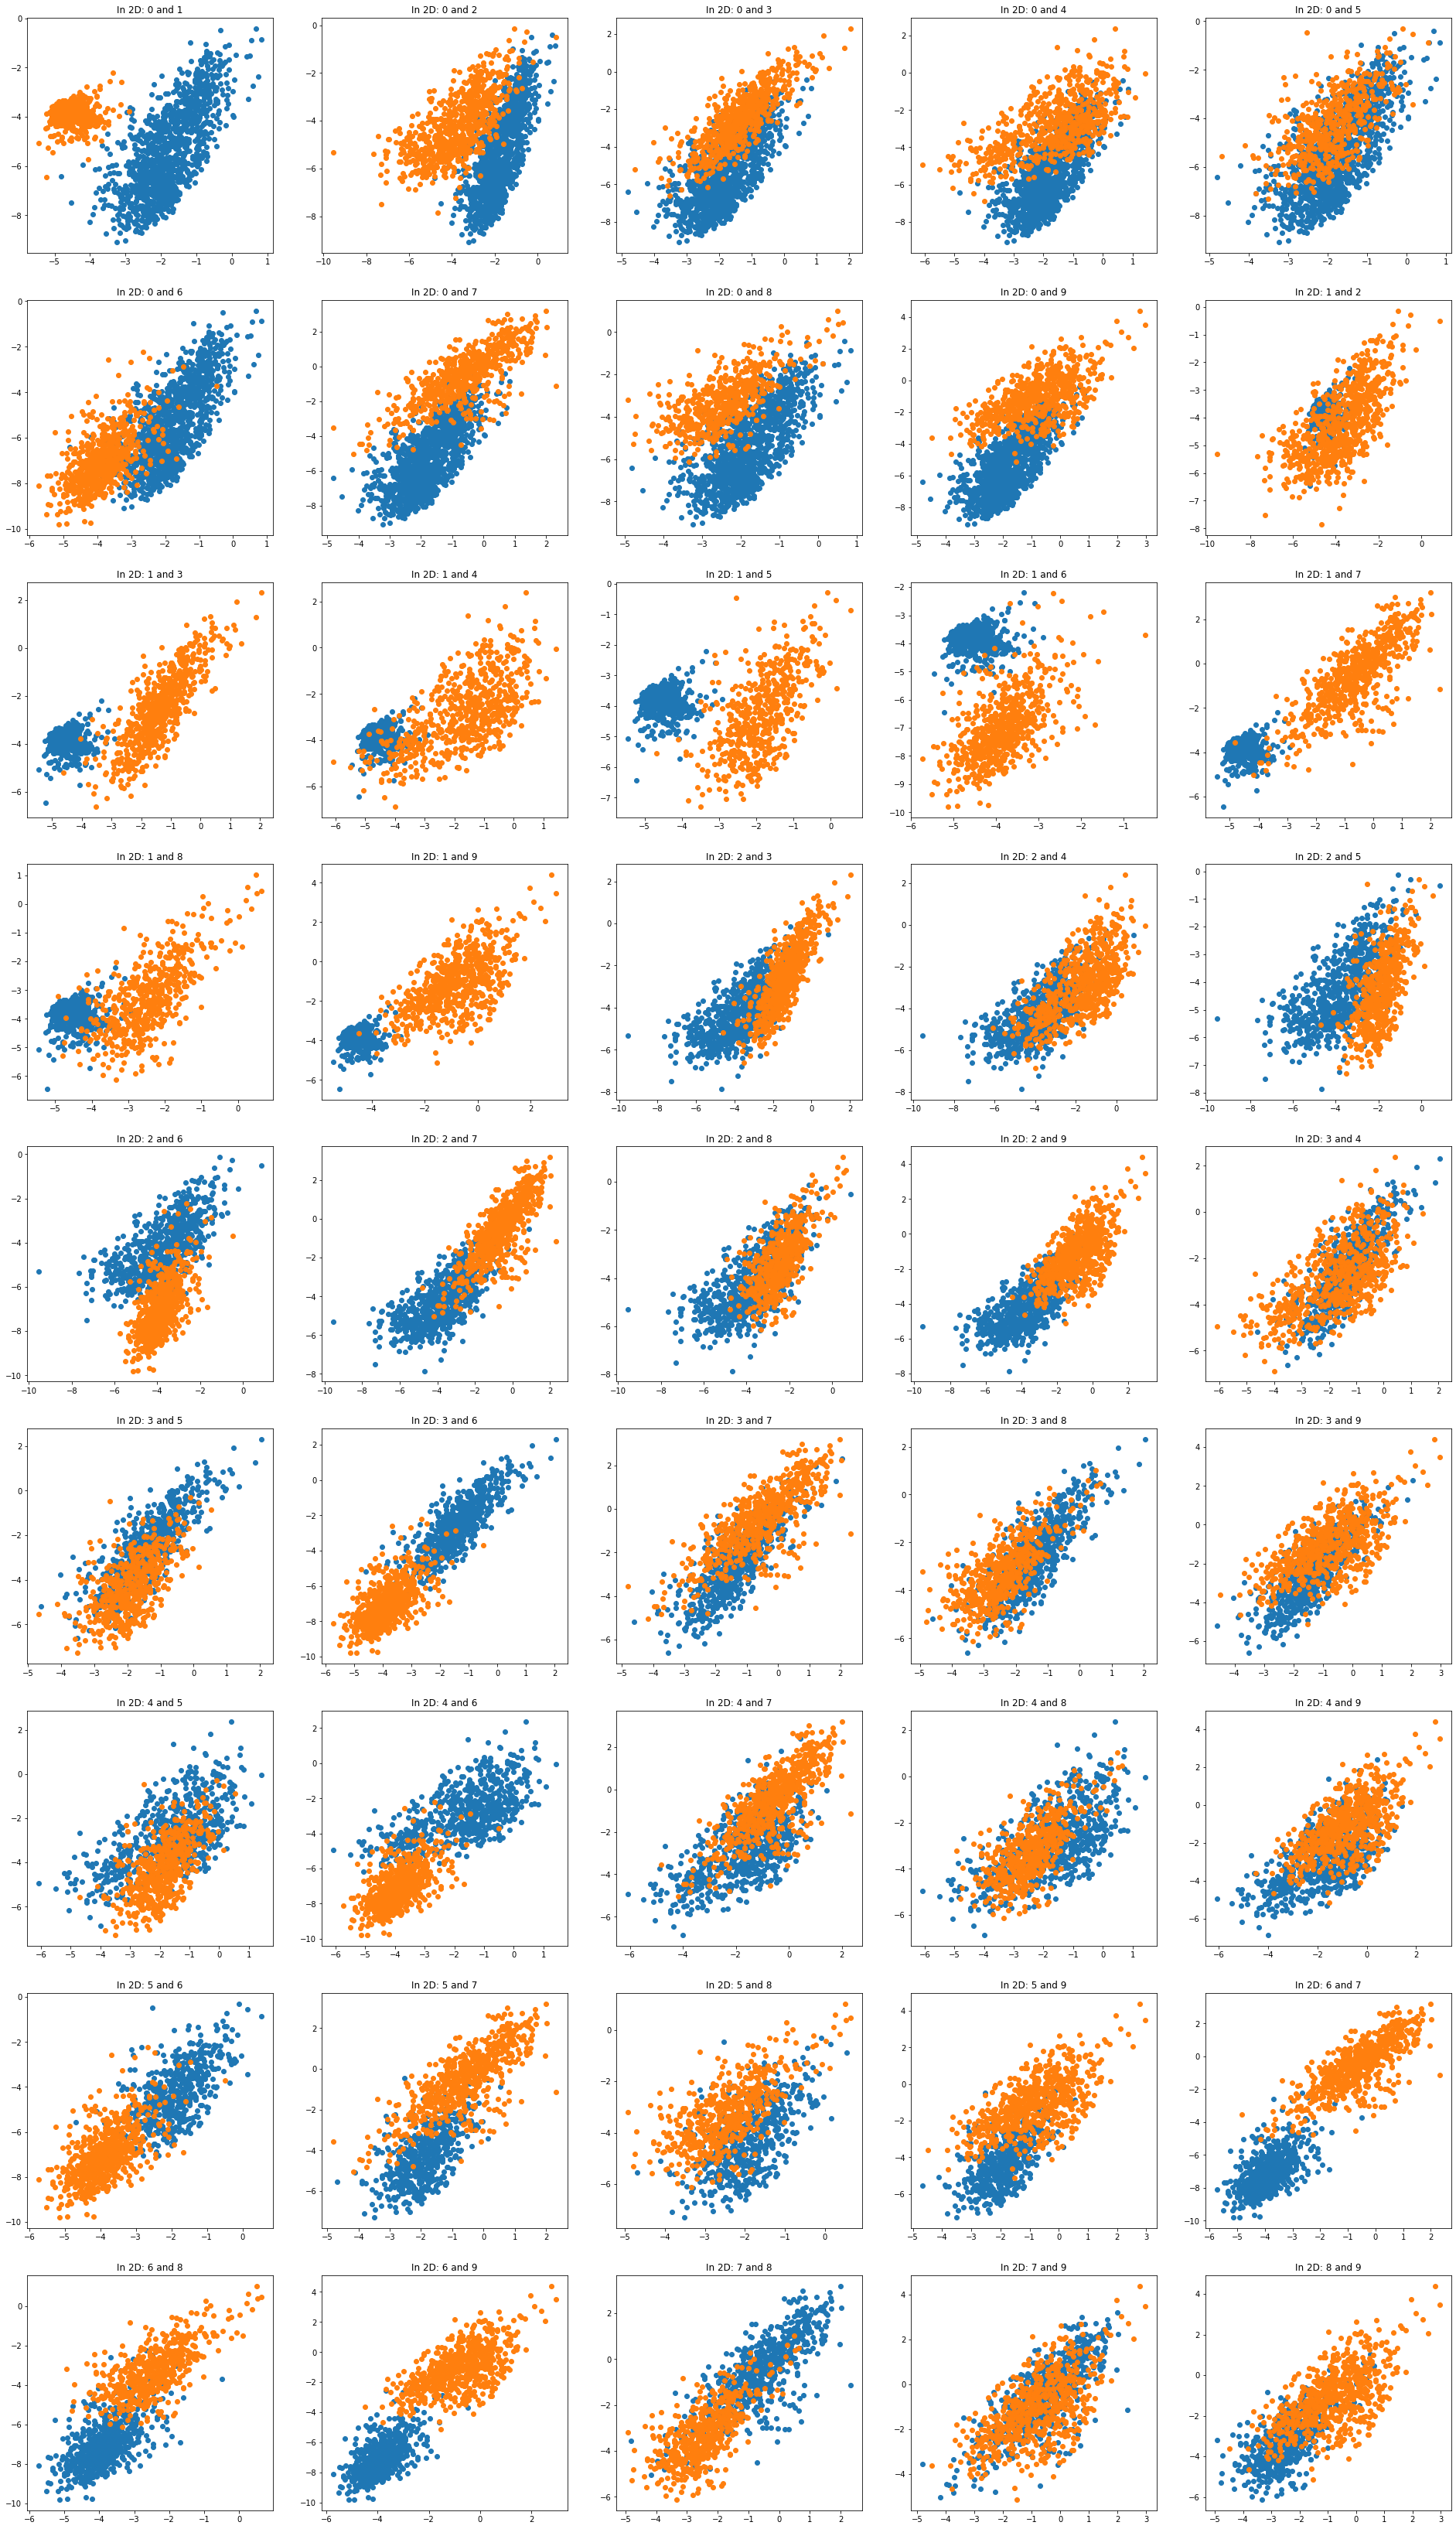

In [251]:
visualizer.show_2d(X_train_2d, y_train)

**Exercise 2**: 

Use your implementation of PCA on the greyscale-version of the "LFWcrop Face"-Dataset1.Visualize the first two principal components as Eigenfaces.

X shape (1288, 1850)

(1288,)
[5 6 3 1 0]

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder']

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
image_height: 50
image_width: 37
(28,)


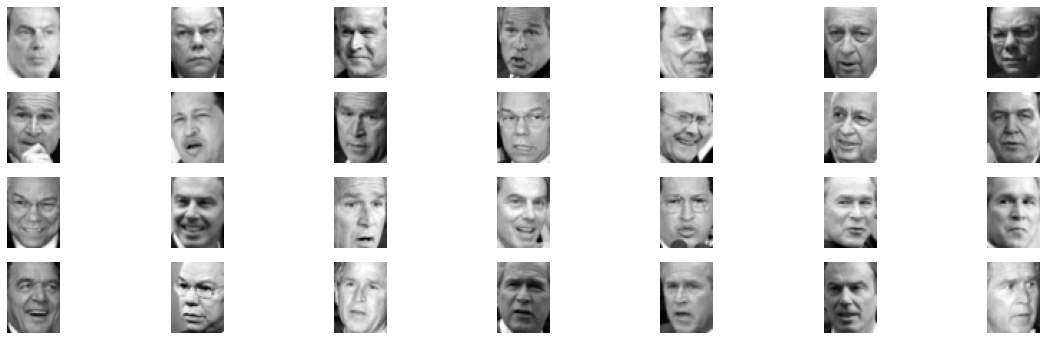

In [252]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
from matplotlib import pyplot as plt


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]
print("X shape",X.shape)
print("")

# the label to predict is the id of the person
y = lfw_people.target
print(y.shape)
print(y[:5])
print("")

target_names = lfw_people.target_names
print(target_names[:5])
print("")

n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
print("image_height: %d" % h)
print("image_width: %d" % w)


def show_faces(X):
    num_samples = 28
    indices = np.random.choice(range(len(X)), num_samples)
#     indices = np.array([0,1,2,3,4,5])
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(4, 7, i + 1)
        img = sample_digits[i].reshape((h, w))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
show_faces(X)

### get the two eigen vectors

In [253]:
eig_vectors = PCA(X, n_features)
eig_vector2 = PCA(compress(X, n_features), n_features)
print(eig_vectors.shape)
print(eig_vector2.shape)
# print(eig_vectors)
# print(eig_vector2)

eig_vectors = np.vstack([eig_vectors, eig_vector2])
print(eig_vectors.shape)

(1850,)
(1850,)
(2, 1850)


In [254]:
X_2d = project(X, eig_vectors)
print(X_2d.shape)
print(X_2d[:5])

(1288, 2)
[[ 178.80440658 -837.04171197]
 [ 163.18371272 -925.26076418]
 [ 144.7472842  -621.57920617]
 [ 205.22405949 -986.95171417]
 [ 230.78712547 -804.45722147]]


## Visualize the first two principal components as Eigenfaces !

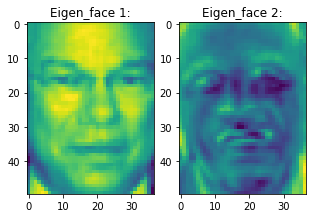

In [255]:
visualizer.eigenfaces(eig_vectors)